In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit

## Setting matplotlib
mpl.rcParams.update({'font.size': 14})
mpl.rcParams.update({'axes.facecolor':'w'})
mpl.rcParams.update({'axes.edgecolor':'k'})
mpl.rcParams.update({'figure.facecolor':'w'})
mpl.rcParams.update({'figure.edgecolor':'w'})
mpl.rcParams.update({'axes.grid':True})
mpl.rcParams.update({'grid.linestyle':':'})
mpl.rcParams.update({'figure.figsize':[12,9]})

#source codeの表示用
from inspect import getsource

# fitting 1-1
[iminuit](https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/)を用いたfittingの基礎。統計誤差のみの場合。ここでは1次関数をフィッテングする。

## 模擬データを作る。

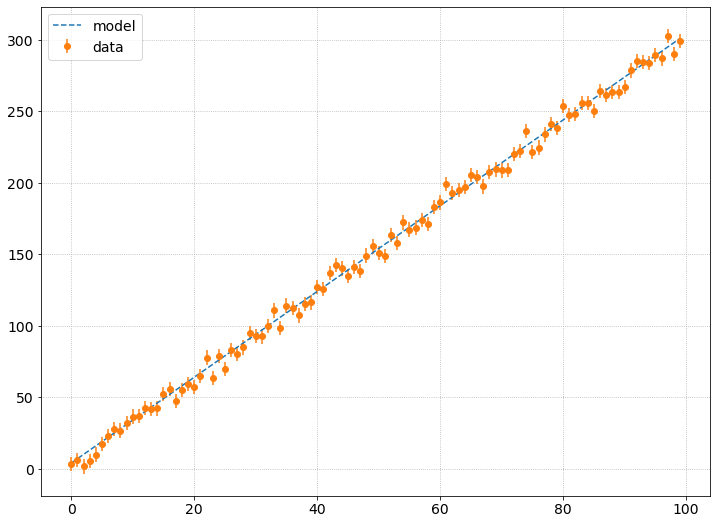

In [37]:
a_model = 3
b_model = 4

#まずは一様なエラーが乗っているような場合
err_model = 5

xdata = np.arange(0, 100, 1)
ymodel = a_model*xdata + b_model
ydata = a_model * xdata + b_model + err_model*np.random.randn(len(xdata))

plt.plot(xdata, ymodel, "--", label="model")
plt.errorbar(xdata, ydata, yerr=err_model, fmt="o", label="data")
plt.legend()

# fitting関数を定義する

In [14]:
def fitfunc(x, a, b):
    return a*x + b

# fittingを行う
一番初めにcost関数(=χ二乗)を定義している。

モデル化を行う際に必要な引数は、
* cost関数: ここではχ二乗
* parameterの初期値: fittingによっては予め大雑把に決めておく必要がある
* errordef: uncertaintyを決めるために必要。χ二乗を最小化する場合にはχ二乗が最小値から1上がる場所が1σなので1に設定する。

である。

In [60]:
#最小化を行う関数を定義
def fit(xdata, ydata, yerr, a_init, b_init):
    def cost(a, b):
        return np.sum((ydata - fitfunc(xdata, a, b))**2 / yerr**2)
    
    #minuitによるfitに必要なパラメータを定義
    error_a = 0.1*a_init
    error_b = 0.1*b_init
    
    #最小化するモデルを定義
    m = Minuit(cost, errordef=1,
              a = a_init, error_a=error_a,
              b = b_init, error_b=error_b)
    
    return m

#実際に最小化を行う
m = fit(xdata=xdata, ydata=ydata, yerr=err_model, a_init=1, b_init=1)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 96.45                      │        Ncalls = 32 (32 total)        │
│ EDM = 2.56e-21 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.007   │   0.017   │            │            │         │         │       │
│ 1 │ b    │    2.8    │    1.0    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

# fittingの結果をプロット

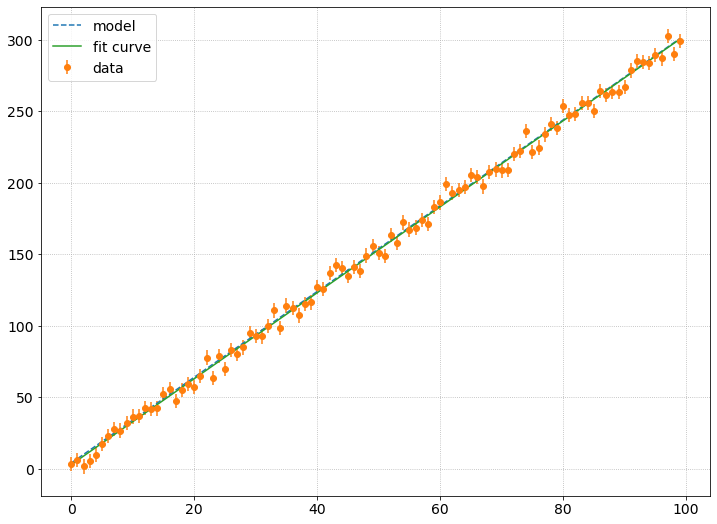

In [65]:
plt.plot(xdata, ymodel, "--", label="model")
plt.errorbar(xdata, ydata, yerr=err_model, fmt="o", label="data")
plt.plot(xdata, fitfunc(xdata, *m.values.values()), label="fit curve")
plt.legend()

# reduced chisqの計算

In [78]:
m.fval / (len(ydata) - m.nfit)

0.984229184419355

# Hesseによるerror barの見積もり
パラメータ空間をparabolicに計算し、errorを見積もる。

Pros:
* 計算が速い。
* Provides covariance matrix for error propagation.


Cons:
* サンプルサイズが小さいときには良い近似にならない可能性がある

In [63]:
m.hesse()

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,3.007,0.017,-0.017,0.017,,,
1,b,2.8,1.0,-1.0,1.0,,,


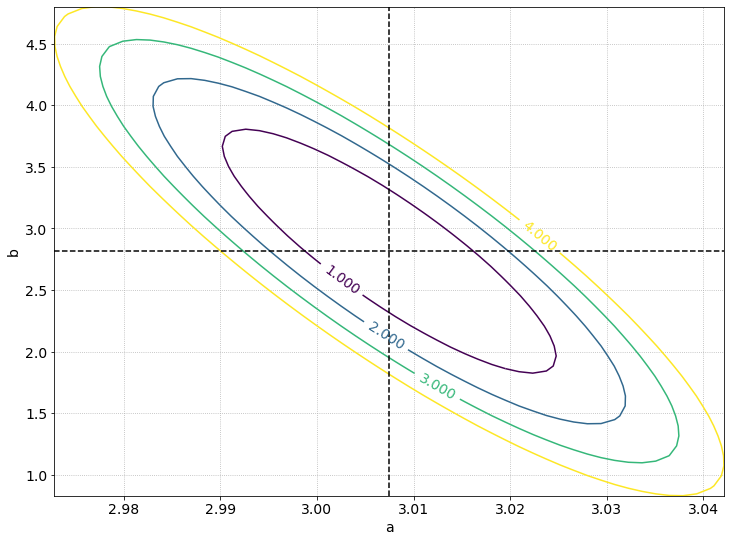

In [70]:
m.draw_contour('a', 'b');

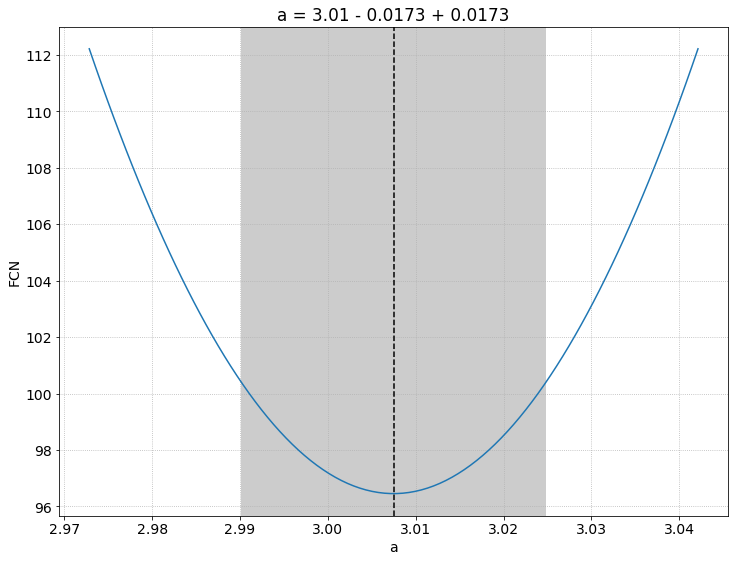

In [72]:
m.draw_profile('a');

# Minosによるerrorの見積もり
コスト関数が最小となる値の周りで、コスト関数を最小からerrordef(chisqなら1)だけ増やす場所をerrorとする方法

Pros:
* 2次元以上のconterを描くことができる

Cons:
* 計算コストが高い
* 非対称なerrorbarがつくのでpropageteを考えるのが難しい。

In [64]:
m.minos()

┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.017   │   0.017   │    -1     │     1     │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘

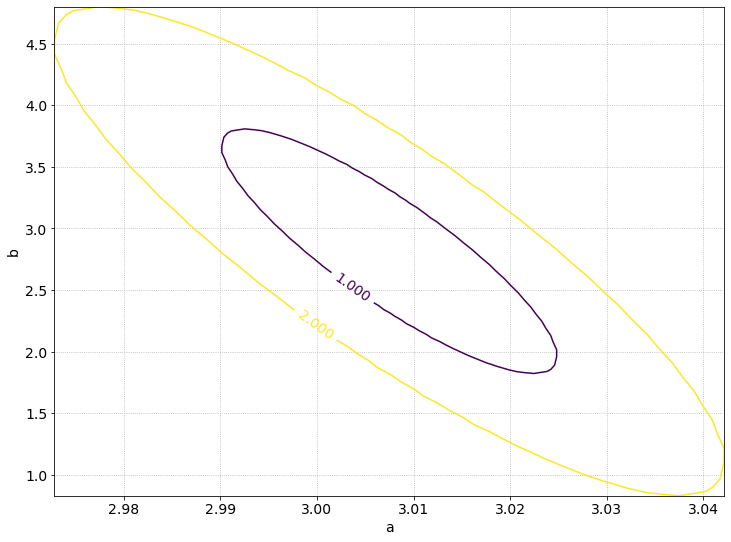

In [66]:
m.draw_mncontour('a','b', nsigma=2)

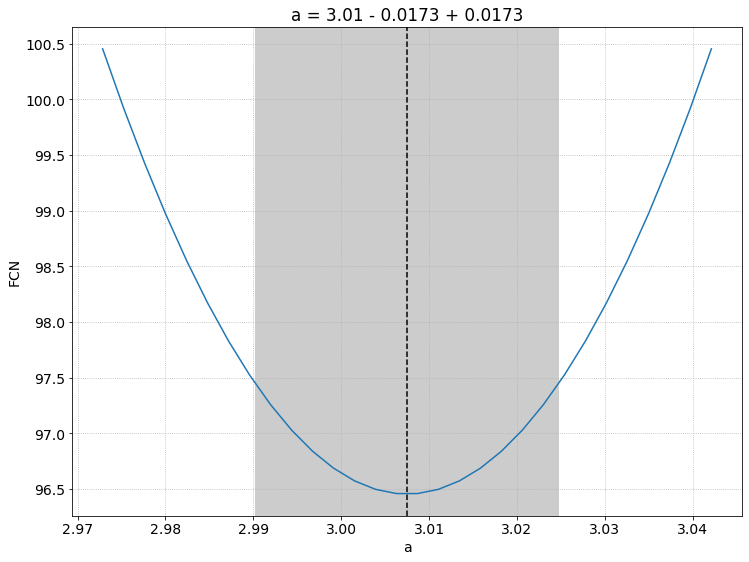

In [67]:
m.draw_mnprofile('a');

_______________________
# 使用したcodeのソース

In [8]:
print(getsource(np.random))

"""
Random Number Generation

Use ``default_rng()`` to create a `Generator` and call its methods.

=============== =========================================================
Generator
--------------- ---------------------------------------------------------
Generator       Class implementing all of the random number distributions
default_rng     Default constructor for ``Generator``
=============== =========================================================

============================================= ===
BitGenerator Streams that work with Generator
--------------------------------------------- ---
MT19937
PCG64
Philox
SFC64
============================================= ===

============================================= ===
Getting entropy to initialize a BitGenerator
--------------------------------------------- ---
SeedSequence
============================================= ===


Legacy
------

For backwards compatibility with previous versions of numpy before 1.17, the
various aliase

In [20]:
print(getsource(plt.errorbar))

@docstring.copy(Axes.errorbar)
def errorbar(
        x, y, yerr=None, xerr=None, fmt='', ecolor=None,
        elinewidth=None, capsize=None, barsabove=False, lolims=False,
        uplims=False, xlolims=False, xuplims=False, errorevery=1,
        capthick=None, *, data=None, **kwargs):
    return gca().errorbar(
        x, y, yerr=yerr, xerr=xerr, fmt=fmt, ecolor=ecolor,
        elinewidth=elinewidth, capsize=capsize, barsabove=barsabove,
        lolims=lolims, uplims=uplims, xlolims=xlolims,
        xuplims=xuplims, errorevery=errorevery, capthick=capthick,
        **({"data": data} if data is not None else {}), **kwargs)

